# Homicide Police Response Prediction

## Imports

In [1]:
import utils

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


## Import data

In [2]:
df = pd.read_excel("./data/homicide-data.xlsx")

## Shuffle and split the data

In [3]:
train_and_valid_set, test_set = train_test_split(df, test_size = 0.2, random_state = 0)
train_set, validation_sat = train_test_split(train_and_valid_set, test_size=0.2, random_state = 0)

## Exploratory data analysis

In [4]:
train_set.sample(10)

uid  reported_date     victim_last  victim_first victim_race  \
17206  Det-000792       20160210        WILLIAMS     JOHNATHON       Black   
37226   NO-001269       20161204           SMITH          TYRE       Black   
955    Atl-001333       20130102       EDMONDSON        ELIJAH       White   
44253  Pit-000290       20130811           SMITH        DARREN       Black   
13675  Col-000224       20140325       ARMSTRONG        DRESAN       Black   
33481  Mia-000540       20140622          GUZMAN        MARTHA       White   
13356  Cin-001055       20160723          ODNEAL  BOBBIE   III       Black   
52024  Was-001222       20071109          HENSON     DEANTHONY       Black   
50257  Tul-000180       20070124         GILBERT         DAVID       White   
22281  Hou-003818       20141208  ROMERO-ALVAREZ      ANGELINA    Hispanic   

      victim_age victim_sex         city state        lat        lon  \
17206         31       Male      Detroit    MI  42.375325 -83.178332   
37226         18       Male  New Orleans    LA  29.965034 -90.073101   
955           23       Male      Atlanta    GA  33.761920 -84.416426   
44253         34       Male   Pittsburgh    PA  40.417225 -79.999013   
13675         18       Male     Columbus    OH  39.955433 -82.951059   
33481         11     Female        Miami    FL  25.777260 -80.208623   
13356         23       Male   Cincinnati    OH  39.149817 -84.551325   
52024         20       Male   Washington    DC  38.875051 -77.010441   
50257         26       Male        Tulsa    OK  36.165640 -95.971930   
22281         50     Female      Houston    TX  29.678214 -95.415765   

            disposition  
17206  Closed by arrest  
37226    Open/No arrest  
955    Closed by arrest  
44253    Open/No arrest  
13675    Open/No arrest  
33481  Closed by arrest  
13356    Open/No arrest  
52024  Closed by arrest  
50257  Closed by arrest  
22281  Closed by arrest

In [5]:
utils.transform_data(train_set)

In [6]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33394 entries, 6163 to 14544
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   reported_date  33394 non-null  datetime64[ns]
 1   victim_race    33394 non-null  category      
 2   victim_age     33394 non-null  int32         
 3   victim_sex     33394 non-null  category      
 4   lat            33359 non-null  float64       
 5   lon            33359 non-null  float64       
 6   disposition    33394 non-null  category      
 7   month          33394 non-null  category      
 8   weekday        33394 non-null  category      
 9   delta_days     33394 non-null  float64       
dtypes: category(5), datetime64[ns](1), float64(3), int32(1)
memory usage: 1.6 MB


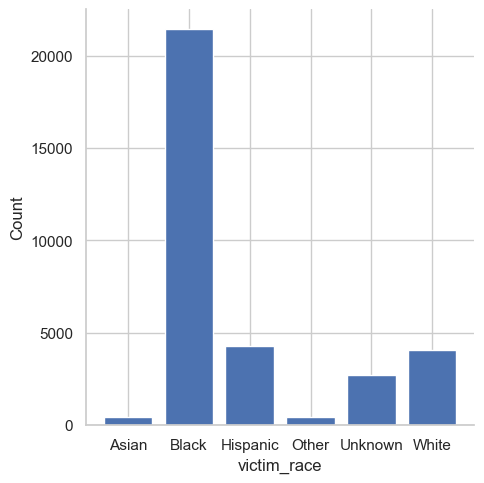

In [7]:
sns.displot(data=train_set, x="victim_race", shrink=0.8, alpha=1)

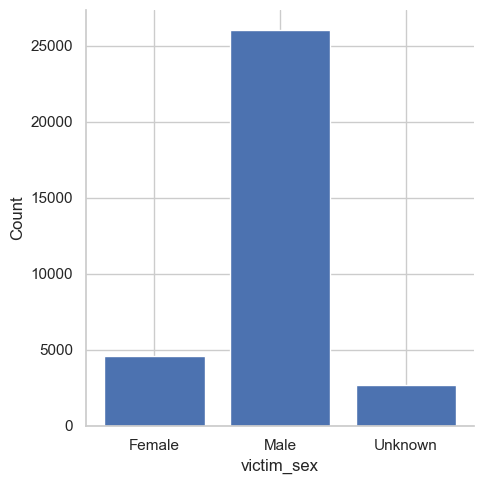

In [56]:
sns.displot(data=train_set, x="victim_sex", shrink=0.8, alpha=1)

<Axes: >

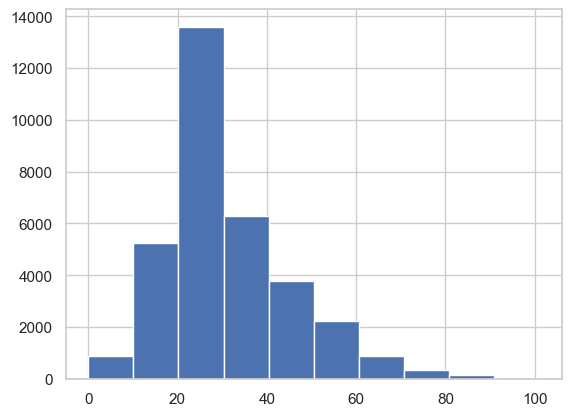

In [61]:
train_set["victim_age"].hist()

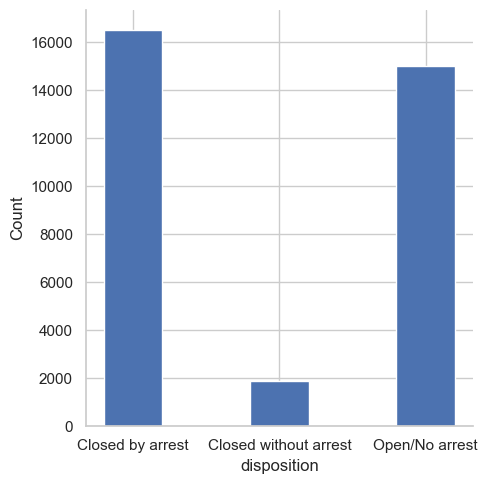

In [8]:
sns.displot(data=train_set, x="disposition", shrink=0.4, alpha=1)

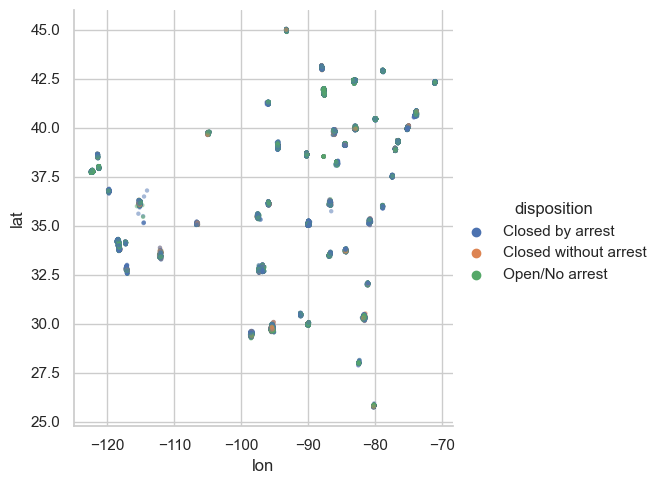

In [54]:
sns.relplot(train_set, x="lon", y="lat", alpha=0.5, hue="disposition", linewidth=0, s=10)

In [10]:
train_set.describe()

reported_date    victim_age           lat  \
count                          33394  33394.000000  33359.000000   
mean   2012-11-06 00:37:20.594118400     29.861233     37.028663   
min              2007-01-01 00:00:00     -1.000000     25.725660   
25%              2010-03-17 00:00:00     21.000000     33.762503   
50%              2012-12-23 12:00:00     27.000000     38.538284   
75%              2015-09-15 00:00:00     39.000000     40.029895   
max              2017-12-31 00:00:00    101.000000     45.051190   
std                              NaN     15.962282      4.354980   

                lon    delta_days  
count  33359.000000  33394.000000  
mean     -91.482557   1880.974067  
min     -122.503286      0.000000  
25%      -95.998378    838.000000  
50%      -87.709572   1833.500000  
75%      -81.748009   2846.000000  
max      -71.011519   4017.000000  
std       13.766350   1163.620589

In [11]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33394 entries, 6163 to 14544
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   reported_date  33394 non-null  datetime64[ns]
 1   victim_race    33394 non-null  category      
 2   victim_age     33394 non-null  int32         
 3   victim_sex     33394 non-null  category      
 4   lat            33359 non-null  float64       
 5   lon            33359 non-null  float64       
 6   disposition    33394 non-null  category      
 7   month          33394 non-null  category      
 8   weekday        33394 non-null  category      
 9   delta_days     33394 non-null  float64       
dtypes: category(5), datetime64[ns](1), float64(3), int32(1)
memory usage: 2.6 MB


## Impute and transform data

In [12]:
age_imputer = SimpleImputer(missing_values = -1, strategy = "median")

In [13]:
train_set["victim_age"] = age_imputer.fit_transform(train_set["victim_age"].values.reshape(-1, 1))[:, 0].astype(int)

In [14]:
coordinate_imputer = SimpleImputer(missing_values = np.nan, strategy = "median")

In [15]:
train_set["lat"] = coordinate_imputer.fit_transform(train_set["lat"].values.reshape(-1, 1))[:, 0]
train_set["lon"] = coordinate_imputer.fit_transform(train_set["lon"].values.reshape(-1, 1))[:, 0]

In [16]:
train_set.describe()

reported_date    victim_age           lat  \
count                          33394  33394.000000  33394.000000   
mean   2012-11-06 00:37:20.594118400     31.554651     37.030245   
min              2007-01-01 00:00:00      0.000000     25.725660   
25%              2010-03-17 00:00:00     22.000000     33.763686   
50%              2012-12-23 12:00:00     28.000000     38.538284   
75%              2015-09-15 00:00:00     39.000000     40.029322   
max              2017-12-31 00:00:00    101.000000     45.051190   
std                              NaN     14.018282      4.352971   

                lon    delta_days  
count  33394.000000  33394.000000  
mean     -91.478603   1880.974067  
min     -122.503286      0.000000  
25%      -95.996832    838.000000  
50%      -87.709572   1833.500000  
75%      -81.752102   2846.000000  
max      -71.011519   4017.000000  
std       13.759676   1163.620589

<Axes: xlabel='month'>

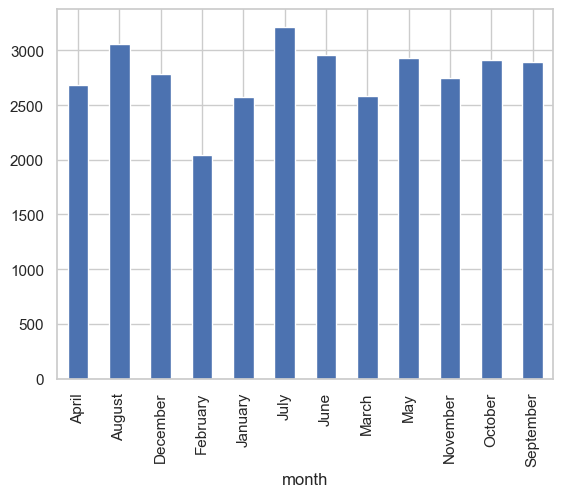

In [17]:
train_set.groupby("month").size().plot(kind="bar")

<Axes: xlabel='weekday'>

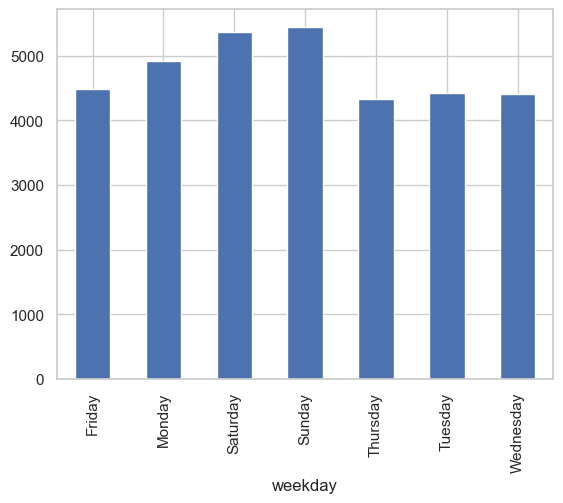

In [18]:
train_set.groupby("weekday").size().plot(kind="bar")

Closed by arrest              Axes(0.1,0.559091;0.363636x0.340909)
Closed without arrest    Axes(0.536364,0.559091;0.363636x0.340909)
Open/No arrest                    Axes(0.1,0.15;0.363636x0.340909)
dtype: object

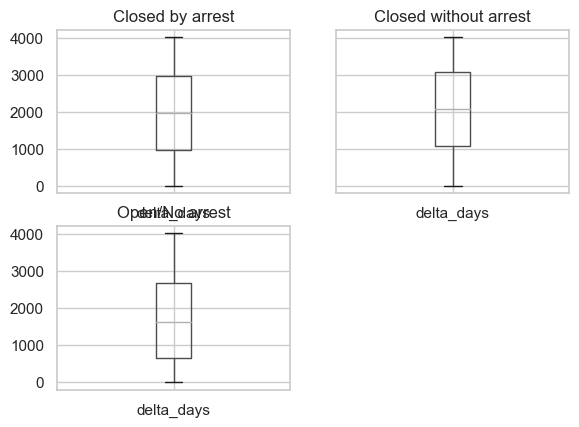

In [19]:
train_set[["delta_days", "disposition"]].groupby("disposition").boxplot()

In [20]:
train_set_onehot = train_set[["victim_race", "victim_sex", "month", "weekday"]]

In [21]:
onehot_encoder = OneHotEncoder(sparse_output = False)

In [22]:
train_set_onehot_array = onehot_encoder.fit_transform(train_set_onehot)

In [23]:
train_set_onehot = pd.DataFrame(train_set_onehot_array,
                               columns = onehot_encoder.get_feature_names_out(),
                               index = train_set_onehot.index).astype(int)

In [24]:
train_set_onehot

victim_race_Asian  victim_race_Black  victim_race_Hispanic  \
6163                   0                  1                     0   
49505                  0                  1                     0   
32106                  0                  1                     0   
30512                  0                  0                     1   
10814                  0                  1                     0   
...                  ...                ...                   ...   
4367                   0                  1                     0   
8607                   0                  0                     0   
18397                  0                  1                     0   
34727                  0                  1                     0   
14544                  0                  0                     0   

       victim_race_Other  victim_race_Unknown  victim_race_White  \
6163                   0                    0                  0   
49505                  0                    0                  0   
32106                  0                    0                  0   
30512                  0                    0                  0   
10814                  0                    0                  0   
...                  ...                  ...                ...   
4367                   0                    0                  0   
8607                   0                    0                  1   
18397                  0                    0                  0   
34727                  0                    0                  0   
14544                  0                    1                  0   

       victim_sex_Female  victim_sex_Male  victim_sex_Unknown  month_April  \
6163                   0                1                   0            0   
49505                  0                1                   0            0   
32106                  0                1                   0            0   
30512                  0                1                   0            0   
10814                  0                1                   0            0   
...                  ...              ...                 ...          ...   
4367                   0                1                   0            0   
8607                   1                0                   0            0   
18397                  0                1                   0            1   
34727                  1                0                   0            0   
14544                  0                0                   1            0   

       ...  month_November  month_October  month_September  weekday_Friday  \
6163   ...               1              0                0               0   
49505  ...               0              0                0               0   
32106  ...               0              0                0               0   
30512  ...               0              0                0               0   
10814  ...               1              0                0               0   
...    ...             ...            ...              ...             ...   
4367   ...               0              0                0               1   
8607   ...               0              0                0               0   
18397  ...               0              0                0               0   
34727  ...               0              0                0               0   
14544  ...               0              0                0               0   

       weekday_Monday  weekday_Saturday  weekday_Sunday  weekday_Thursday  \
6163                1                 0               0                 0   
49505               0                 0               0                 0   
32106               0                 0               1                 0   
30512               0                 0               0                 0   
10814               0                 0               1                 0   
...               ...    

In [25]:
train_set_num = train_set[["victim_age", "lat", "lon", "delta_days"]]

In [26]:
std_scaler = StandardScaler()

In [27]:
train_set_num_scaled = std_scaler.fit_transform(train_set_num)

In [28]:
train_set_num_scaled

array([[-0.46758574,  1.34950783,  0.92026706,  0.92731437],
       [ 0.60246156,  0.3592794 ,  0.08834186, -1.48072308],
       [ 1.60117237, -0.44393924,  0.10202153, -0.0283379 ],
       ...,
       [-0.25357628,  1.23972113,  0.59619127, -0.77687488],
       [ 0.95914399,  1.39924612,  0.25362901,  0.70215169],
       [-0.25357628, -0.99320504, -0.38997934,  1.83140266]])

In [29]:
train_set_num = pd.DataFrame(train_set_num_scaled,
                            columns = std_scaler.get_feature_names_out(),
                            index = train_set_num.index)

In [30]:
train_set_num

victim_age       lat       lon  delta_days
6163    -0.467586  1.349508  0.920267    0.927314
49505    0.602462  0.359279  0.088342   -1.480723
32106    1.601172 -0.443939  0.102022   -0.028338
30512    0.388452 -0.696878 -1.961384   -1.173917
10814   -0.681595  1.087272  0.279769   -0.647965
...           ...       ...       ...         ...
4367    -0.681595 -1.515048  0.021951   -0.471788
8607     0.031770  1.135495  0.273260    0.913564
18397   -0.253576  1.239721  0.596191   -0.776875
34727    0.959144  1.399246  0.253629    0.702152
14544   -0.253576 -0.993205 -0.389979    1.831403

[33394 rows x 4 columns]

In [31]:
train_set_transformed = pd.concat((train_set_onehot, train_set_num), axis = 1)

In [32]:
train_set_transformed

victim_race_Asian  victim_race_Black  victim_race_Hispanic  \
6163                   0                  1                     0   
49505                  0                  1                     0   
32106                  0                  1                     0   
30512                  0                  0                     1   
10814                  0                  1                     0   
...                  ...                ...                   ...   
4367                   0                  1                     0   
8607                   0                  0                     0   
18397                  0                  1                     0   
34727                  0                  1                     0   
14544                  0                  0                     0   

       victim_race_Other  victim_race_Unknown  victim_race_White  \
6163                   0                    0                  0   
49505                  0                    0                  0   
32106                  0                    0                  0   
30512                  0                    0                  0   
10814                  0                    0                  0   
...                  ...                  ...                ...   
4367                   0                    0                  0   
8607                   0                    0                  1   
18397                  0                    0                  0   
34727                  0                    0                  0   
14544                  0                    1                  0   

       victim_sex_Female  victim_sex_Male  victim_sex_Unknown  month_April  \
6163                   0                1                   0            0   
49505                  0                1                   0            0   
32106                  0                1                   0            0   
30512                  0                1                   0            0   
10814                  0                1                   0            0   
...                  ...              ...                 ...          ...   
4367                   0                1                   0            0   
8607                   1                0                   0            0   
18397                  0                1                   0            1   
34727                  1                0                   0            0   
14544                  0                0                   1            0   

       ...  weekday_Monday  weekday_Saturday  weekday_Sunday  \
6163   ...               1                 0               0   
49505  ...               0                 0               0   
32106  ...               0                 0               1   
30512  ...               0                 0               0   
10814  ...               0                 0               1   
...    ...             ...               ...             ...   
4367   ...               0                 0               0   
8607   ...               0                 0               0   
18397  ...               0                 0               0   
34727  ...               0                 0               0   
14544  ...               0                 1               0   

       weekday_Thursday  weekday_Tuesday  weekday_Wednesday  victim_age  \
6163                  0                0                  0   -0.467586   
49505                 0                0                  1    0.602462   
32106                 0                0                  0    1.601172   
30512                 0                0                  1    0.388452   
10814                 0                0                  0   -0.681595   
...                 ...              ...                ...         ...   
4367                  0                0                  0   -0.681595   
8607                  0                0               

## Make pipelines

In [35]:
age_pipeline = Pipeline([
    ("impute", age_imputer),
    ("standardize", std_scaler),
])

coordinate_pipeline = Pipeline([
    ("impute", coordinate_imputer),
    ("standardize", std_scaler)
])

delta_days_pipeline = Pipeline([
    ("standardize", std_scaler)
])

onehot_pipeline  = Pipeline([
    ("onehot", onehot_encoder)
])

preprocessing = ColumnTransformer([
    ("age", age_pipeline, ["victim_age"]),
    ("coordinates", coordinate_pipeline, ["lat", "lon"]),
    ("delta_days", delta_days_pipeline, ["delta_days"]),
    ("onehot", onehot_pipeline, ["victim_race", "victim_sex", "month", "weekday"])
])

In [36]:
train_set_prepared = preprocessing.fit_transform(train_set.drop("disposition", axis=1))

In [37]:
train_set_prepared.shape

(33394, 32)

In [38]:
preprocessing.get_feature_names_out()

array(['age__victim_age', 'coordinates__lat', 'coordinates__lon',
       'delta_days__delta_days', 'onehot__victim_race_Asian',
       'onehot__victim_race_Black', 'onehot__victim_race_Hispanic',
       'onehot__victim_race_Other', 'onehot__victim_race_Unknown',
       'onehot__victim_race_White', 'onehot__victim_sex_Female',
       'onehot__victim_sex_Male', 'onehot__victim_sex_Unknown',
       'onehot__month_April', 'onehot__month_August',
       'onehot__month_December', 'onehot__month_February',
       'onehot__month_January', 'onehot__month_July',
       'onehot__month_June', 'onehot__month_March', 'onehot__month_May',
       'onehot__month_November', 'onehot__month_October',
       'onehot__month_September', 'onehot__weekday_Friday',
       'onehot__weekday_Monday', 'onehot__weekday_Saturday',
       'onehot__weekday_Sunday', 'onehot__weekday_Thursday',
       'onehot__weekday_Tuesday', 'onehot__weekday_Wednesday'],
      dtype=object)

## Select and train a model

In [116]:
from sklearn import set_config
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import CategoricalNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

In [40]:
set_config(transform_output="pandas")

In [41]:
tree_classifier = Pipeline([
    ("preprocess", preprocessing),
    ("train", DecisionTreeClassifier())
])

In [42]:
bagging_classifier = Pipeline([
    ("preprocess", preprocessing),
    ("train", BaggingClassifier())
])

In [112]:
gradient_boosting_classifier = Pipeline([
    ("preprocess", preprocessing),
    ("train", GradientBoostingClassifier(learning_rate=0.2))
])

In [117]:
categorical_naive_bayes_classifier = Pipeline([
    ("preprocess", preprocessing),
    ("train", GradientBoostingClassifier())
])

In [44]:
tree_classifier.fit(X=train_set, y=train_set.loc[:, "disposition"])

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('age',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(missing_values=-1,
                                                                                 strategy='median')),
                                                                  ('standardize',
                                                                   StandardScaler())]),
                                                  ['victim_age']),
                                                 ('coordinates',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardize',
                                                                   StandardScaler())]),
                                                  ['lat', 'lon']),
                                                 ('delta_days',
                                                  Pipeline(steps=[('standardize',
                                                                   StandardScaler())]),
                                                  ['delta_days']),
                                                 ('onehot',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(sparse_output=False))]),
                                                  ['victim_race', 'victim_sex',
                                                   'month', 'weekday'])])),
                ('train', DecisionTreeClassifier())])

In [45]:
bagging_classifier.fit(train_set, train_set["disposition"])

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('age',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(missing_values=-1,
                                                                                 strategy='median')),
                                                                  ('standardize',
                                                                   StandardScaler())]),
                                                  ['victim_age']),
                                                 ('coordinates',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardize',
                                                                   StandardScaler())]),
                                                  ['lat', 'lon']),
                                                 ('delta_days',
                                                  Pipeline(steps=[('standardize',
                                                                   StandardScaler())]),
                                                  ['delta_days']),
                                                 ('onehot',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(sparse_output=False))]),
                                                  ['victim_race', 'victim_sex',
                                                   'month', 'weekday'])])),
                ('train', BaggingClassifier())])

In [118]:
gradient_boosting_classifier.fit(train_set, train_set["disposition"])

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('age',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(missing_values=-1,
                                                                                 strategy='median')),
                                                                  ('standardize',
                                                                   StandardScaler())]),
                                                  ['victim_age']),
                                                 ('coordinates',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardize',
                                                                   StandardScaler())]),
                                                  ['lat', 'lon']),
                                                 ('delta_days',
                                                  Pipeline(steps=[('standardize',
                                                                   StandardScaler())]),
                                                  ['delta_days']),
                                                 ('onehot',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(sparse_output=False))]),
                                                  ['victim_race', 'victim_sex',
                                                   'month', 'weekday'])])),
                ('train', GradientBoostingClassifier(learning_rate=0.2))])

In [119]:
categorical_naive_bayes_classifier.fit(train_set, train_set["disposition"])

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('age',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(missing_values=-1,
                                                                                 strategy='median')),
                                                                  ('standardize',
                                                                   StandardScaler())]),
                                                  ['victim_age']),
                                                 ('coordinates',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardize',
                                                                   StandardScaler())]),
                                                  ['lat', 'lon']),
                                                 ('delta_days',
                                                  Pipeline(steps=[('standardize',
                                                                   StandardScaler())]),
                                                  ['delta_days']),
                                                 ('onehot',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(sparse_output=False))]),
                                                  ['victim_race', 'victim_sex',
                                                   'month', 'weekday'])])),
                ('train', GradientBoostingClassifier())])

In [120]:
features = pd.DataFrame(categorical_naive_bayes_classifier.steps[-1][1].feature_importances_, index=gradient_boosting_classifier.steps[-1][1].feature_names_in_, columns=["Importance"])
features.sort_values("Importance", ascending=False)

Importance
coordinates__lat                0.350811
coordinates__lon                0.147754
delta_days__delta_days          0.140669
age__victim_age                 0.124116
onehot__victim_sex_Female       0.083747
onehot__victim_race_White       0.076466
onehot__victim_sex_Male         0.031408
onehot__victim_race_Black       0.012097
onehot__month_December          0.005200
onehot__victim_race_Asian       0.003097
onehot__month_February          0.003080
onehot__month_March             0.002897
onehot__month_November          0.002356
onehot__victim_race_Unknown     0.002220
onehot__victim_sex_Unknown      0.002091
onehot__month_October           0.002066
onehot__month_July              0.001842
onehot__weekday_Tuesday         0.001691
onehot__weekday_Friday          0.001501
onehot__weekday_Wednesday       0.000717
onehot__month_April             0.000694
onehot__month_September         0.000614
onehot__month_January           0.000568
onehot__weekday_Monday          0.000469
onehot__month_June              0.000381
onehot__weekday_Saturday        0.000339
onehot__weekday_Sunday          0.000296
onehot__weekday_Thursday        0.000295
onehot__victim_race_Hispanic    0.000238
onehot__month_August            0.000179
onehot__victim_race_Other       0.000100
onehot__month_May               0.000000

In [49]:
utils.transform_data(validation_sat)

In [50]:
labels = validation_sat["disposition"]

In [69]:
dtc_scores = cross_val_score(tree_classifier, train_set, train_set["disposition"], scoring="accuracy", cv=10)

In [74]:
pd.Series(dtc_scores).describe()

count    10.000000
mean      0.523747
std       0.004966
min       0.515269
25%       0.520174
50%       0.524259
75%       0.527813
max       0.530240
dtype: float64

In [70]:
bc_scores = cross_val_score(bagging_classifier, train_set, train_set["disposition"], scoring="accuracy", cv=10)

In [75]:
pd.Series(bc_scores).describe()

count    10.000000
mean      0.571989
std       0.005903
min       0.562144
25%       0.569364
50%       0.571578
75%       0.575000
max       0.582510
dtype: float64

In [114]:
gbc_scores = cross_val_score(gradient_boosting_classifier, train_set, train_set["disposition"], scoring="accuracy", cv=10)

In [115]:
pd.Series(gbc_scores).describe()

count    10.000000
mean      0.601396
std       0.007061
min       0.590895
25%       0.597889
50%       0.599790
75%       0.605285
max       0.616053
dtype: float64

In [121]:
cnbc_scores = cross_val_score(categorical_naive_bayes_classifier, train_set, train_set["disposition"])

In [122]:
pd.Series(cnbc_scores).describe()

count    5.000000
mean     0.599868
std      0.006732
min      0.592903
25%      0.595448
50%      0.598233
75%      0.602785
max      0.609972
dtype: float64

The gradient boosting classifier seems to be the most accurate at predicting disposition.

## Comparison with random choice

In [124]:
# Sample dataset with categorical labels (replace with your dataset)
labels = train_set["disposition"]

# Calculate the frequency of each category
unique_labels, label_counts = np.unique(labels, return_counts=True)

# Total number of data points
total_data_points = len(labels)

# Calculate the probability of each category
label_probabilities = label_counts / total_data_points

# Calculate the overall probability of correctly guessing at random
probability_correct_guess = np.max(label_probabilities)

print("Category Frequencies:")
for label, count, probability in zip(unique_labels, label_counts, label_probabilities):
    print(f"Label: {label}, Count: {count}, Probability: {probability:.2f}")

print(f"Overall Probability of Correct Guess: {probability_correct_guess:.2f}")


Category Frequencies:
Label: Closed by arrest, Count: 16513, Probability: 0.49
Label: Closed without arrest, Count: 1866, Probability: 0.06
Label: Open/No arrest, Count: 15015, Probability: 0.45
Overall Probability of Correct Guess: 0.49
